# Reinforcement Learning with Keras and OpenAI

## Paperwork

The following tutorial tries to teach the basics of reinforcement learning, a special area of machine learning in which machines are trained to take certain actions based on respective rewards which they ought to maximize.

In order to follow along the tutorial without any issues, please make sure to have the following packages installed in your environment: 

"insert yml list here"

Alternatively, you may also download the docker image "jabusch24/force-keras" and run the command "docker run -it --name hype -v /some/path:/app/work jabusch24/force-keras"

## Reinforcement Learning's Position in the World

![title](img/RLworld1.png)

Reinforcement Learning is one paradigm of machine learning, often positioned next to supervised and unsupervised learning. The three categories are different in their input data and the way their algorithms handle the data. 

The **unsupervised learning** paradigm receives data as input without any prior knowledge regarding labels or in other words what the data could possibly tell and as an output provides a pure statistical view of structures in the data. 

**Supervised learning** algorithms receive training data that presents already labeled datasets which the algorithm can work with to improve its estimations of "real" unlabeled data. 

The last paradigm, **reinforcement learning**, does not involve a big chunk of input data. The input data is rather generated on the fly while the algorithm interacts with a previously defined environment. The environment involves a system of rewards which builds the foundation of the algorithm's learning process. 

![title](img/mlalgorithms.png)
source: https://adgefficiency.com/energy_py-reinforcement-learning-for-energy-systems/

![title](img/mlalgorithms_detail.png)
source: https://www.researchgate.net/figure/Basic-structures-of-the-three-learning-paradigms-supervised-learning-reinforcement_fig1_260652455

# Simply speaking...

Reinforcement learning was majorly inspired by behaviourist psychology. To understand this context a bit better let's take a quick look at what "behaviors" actually are, e.g. human behaviors. 

### Behaviorism

Behaviors are based on the assumption that "all behavior, no matter how complex, can be reduced to a simple **stimulus-response association**."¹ This implies that human beings (and animals as well) are shaped entirely by their external environment. 

¹source: https://www.simplypsychology.org/behaviorism.html

An example of this stimulus-response association is a mouse expecting a reward (e.g. food) after a certain behavior (e.g. pushing a lever). In such a case, the stimulus has been induced to an extend that the mouse is proactively pursuing the behavior. This is called **operant conditioning** as opposed to classical conditioning, in which the stimulus is triggered by a neutral signal before a reflex. 

![title](img/classicaloperandcond.jpg)
source: https://psychologenie.com/difference-between-operant-classical-conditioning

### From a brain's perspective

While behaviorism is a research area of psychology, there have also been major findings in neurology, describing the reward systems from a brain pathway perspective. The so called **mesolimbic pathway** was found to be responsible for our understanding of rewards and the memory thereof. 

The mesolimbic pathway is a dopaminergic one, meaning that it consists of neurons that synthesize and release the neurotransmitter **dopamine**. Dopamine is the brain's way of storing information on both rewards and punishments. So in order for us to remember a very pleasant or very unpleasant experience, we need dopamine, and dopamine is produced in the **ventral tegmental area**. 

![title](img/reward-pathway.jpg)
source: http://discovermagazine.com/2015/may/17-resetting-the-addictive-brain

### Connecting the dots

In order to move from psychology and neurology to reinforcement learning, let's capture the basic assumptions which are carried from the two scientific  disciplines into the reinforcement learning algorithm:

- **Behaviorism**: Human beings are shaped by their external environment
- **Operant Conditioning**: Actions are followed by a reward or punishment
- **Mesolimbic Pathway**: Reward and punishment are regulated by an interpreter (VTA)

The idea is to build an algorithm that implements all of the bullet points above. It should behave according to the external environment, the algorithm's actions should be followed by a reward or punishment which is regulated by some interpreter (e.g VTA). 

# Mathematically speaking...

In order to understand reinforcement learning also in a mathematical sense, we'll make use of a simple example of an environment. Let's start by building our components conceptually. To keep it simple, we'll use some aliases that make it easy to understand the abstraction:

### Open AI Gym: Dagobert and the 5 boxes

- Dagobert alias Agent
- Box 0-4 alias Environment
- Move alias Action
- Coin alias Reward

The game works as follows:
We start by placing Dagobert in box 0. No coins given. Dagobert always has two options: He can either go one box further (Move 1), or he can go back to box 0 (Move 0). In principal, Dagobert doesn't receive any coins for moving into the next box (1), however, he receives 2 coins (as defined by the game rules alias interpreter) for every time he goes back to box 0. There are two special cases: When Dagobert is in box 0 and and chooses to make move 0 (backward), then he simply stays in box 0 and gets 2 coins nonetheless AND when Dagobert is in box 4. Once Dagobert reaches box 4 and decides to make another move 1 (forward), the rules say that he shall get 10 coins and remain in box 4. 
So in theory, Dagobert could now repeat move 1 infinitely in box 4 to receive an infininite amount of treats. However, because the game involves randomness, it sometimes happens that Dagobert wants to make a certain move but is then led into the opposite direction. So eventually, Dagobert will be guided backwards, even if he attempts to move forwards and vice versa. 
The game finishes automatically after 1000 steps have been taken.

![title](img/dagobert.png)

### Stupid Dagobert

Dagobert's goal is to maximize the amount of coins he receives within any given round of 1000 steps. A simple approach for maximization is to just run through the game one by one and store the reward Dagobert gets after each move. This would be like giving Dagobert pen and paper and let him run through the game while taking notes on the number of coins he gets after each move. The result would by a table like this: 

![title](img/dago-table.png)

As Dagobert never receives any coins for making move 0 EXCEPT when he's in box 4, there likely won't be any coins in any of those cells. However, due to the random hits inside the game, there might be some coins that have occasionally been produced involuntarily.

Let's simulate running through this game once to showcase how it's done in code:

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [3]:
# initialize the environment, e.g. built up the boxes and create Dagobert
env = gym.make('NChain-v0')

In [3]:
# create table to store the rewards in, e.g. Dagobert's notebook 
coins = np.zeros((5, 2))
moves = np.zeros((5, 2))
coins

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

The table above (r_table) represents our empty table to keep record of the coins we receive for every move from every box. c_table similarly stores the number of moves Dagobert decides to make depending on the box. 

The following code runs through one game of Gym and then shows us how many coins Dagobert has received in every move and also at which box he made which move.

In [87]:
# make sure the environment is reset, e.g. Dagobert has no coins and starts in box 0
s = env.reset()
# make sure the game is not already considered done
done = False
# go through loop as long as game is ongoing
while not done:
    # check out if there is any information on prior rewards for certain actions in this state
    # e.g. check whether Dagobert ever received coins when moving from this box. If no, execute: 
    if np.sum(coins[s, :]) == 0:
        # make a random selection of actions, e.g. moves
        a = np.random.randint(0, 2)
        # uncomment if you want to follow along with the game
        #print(s, a)
    else:
        # given that there is prior reward information, we choose the move with larger prior reward, e.g. coins
        a = np.argmax(coins[s, :])
        # uncomment if you want to follow along with the game
        #print("Box: ", s, ", Move: ", a)
    # make the move and store the information in new variables
    new_s, r, done, _ = env.step(a)
    # add the reward to the table, e.g. Dagobert adds the coins to his notebook
    coins[s, a] += r
    moves[s, a] += 1
    # set the state, e.g. box, to the new number
    s = new_s

0 0
1 1
0 0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
2 1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  2 , Move:  1
3 0
4 1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  2 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  2 , Move:  1
3 1
Box:  4 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box

Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  2 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Move:  1
Box:  0 , Move:  0
Box:  1 , Mo

In [88]:
print("table of coins collected on each move: \n", coins)
print("total sum of coins: \n", np.sum(coins))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)

table of coins collected on each move: 
 [[194.   0.]
 [  0. 676.]
 [  0. 108.]
 [  0.  24.]
 [  0.  16.]]
total sum of coins: 
 1018.0
# of times the move was chosen: 
 [[505.   0.]
 [  0. 407.]
 [  0.  69.]
 [  2.  13.]
 [  0.   4.]]


In most runs, we will receive zeros for the cells [0:3,0], e.g. Boxes 0-3 with a following move 0. It does happen that in some runs, one or more of these cells have very high values as opposed to the "Move 1" column. This can happen due to the randomness that hits roughly once in 8 moves. **Dagobert unfortunately doesn't notice the randomness, and thus, for example, if he decides to make move 0 in box 2 but the randomness forces him to make move 1, then he will still note down "Box 2, Move 0: 2 coins".**

Now, let's give Dagobert the chance to repeat the gym game a couple of times, e.g. filling his notebook table with more and more information on the coins he gets for certain moves in certain boxes by simply wrapping the previous code with another for loop:

In [7]:
def plot_bar(a, b):
    barWidth = 0.5
    b1 = np.arange(len(a))
    b2 = [x + barWidth for x in b1]
    plt.bar(b1, a, width = barWidth, align='center', color='red')
    plt.bar(b2, b, width = barWidth, align='center', color='blue')
    plt.show()

In [73]:
coins = np.zeros((5, 2))
moves = np.zeros((5, 2))
for i in range(1):
    s = env.reset()
    done = False
    while not done:
        if np.sum(coins[s, :]) == 0:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(coins[s, :])
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 1
        s = new_s
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        #plot_bar(coins[:,0],coins[:,1])
        #time.sleep(0.001)
print("table of coins collected on each move: \n", coins)
print("total sum of coins: \n", np.sum(coins))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)

table of coins collected on each move: 
 [[   0. 1322.]
 [   0.  216.]
 [   0.   50.]
 [   0.   14.]
 [   0.    8.]]
total sum of coins: 
 1610.0
# of times the move was chosen: 
 [[  2. 803.]
 [  0. 144.]
 [  3.  33.]
 [  0.  11.]
 [  0.   4.]]


As a simple comparison, if Dagobert were to ALWAYS make move 1 in EVERY step of the game, he often ends up with ~ 160000 coins. That's more than the average stupid Dagobert reaches:

In [78]:
coins = np.zeros((5, 2))
moves = np.zeros((5, 2))
for i in range(500):
    s = env.reset()
    done = False
    while not done:
        a = 1
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 0
        # set the state, e.g. box, to the new number
        s = new_s
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        #plot_bar(coins[:,0],coins[:,1])
        #time.sleep(0.001)
print("table of coins collected on each move: \n", coins)
print("total sum of coins: \n", np.sum(coins)/500)
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)

table of coins collected on each move: 
 [[     0. 641040.]
 [     0. 127398.]
 [     0.  25630.]
 [     0.   5022.]
 [     0.   2896.]]
total sum of coins: 
 1603.972
# of times the move was chosen: 
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


So it is clear that at this point, Dagobert has some sort of idea on how to play the game but since he's only recording the quick wins of the game, he overlooks the bigger picture. His table will not tell him, that it might be worth not getting any coins for 4 consecutive to then get 10 coins for every single move, i.e. move from Box 0 to 4 and then keep repeating move 0. Furthermore, due to the simplicity of the model, Dagobert is locked in as soon as he gains any coins at all.

So we need a smarter way to do this. 

### Giving Dagobert the Power of Q-Learning

Q-Learning is a reinforcement learning technique that's based on developing policies that guide the agent based on the circumstances of any given game.

It basically means that Dagobert is no longer just regarding the immediate rewards. With Q-Learning, he will be able to make decisions based on the overall quality of a decision on the game. In order for Q-Learning to work, the game needs to satisfy the Markov Property, which basically says that any state at time t+1 only depends on the state and the action of time t. In other words, if, Dagobert makes a move 0 from Box 2, then the result should not be in any way depend on Dagoberts previous decisions. Luckily, that is the case in our game.

Now what we are trying to do is to propagate future results to earlier actions. So optimally, Dagobert already knows in box 0 that he can expect a reward of 10 if he reaches box 4 and makes move 0. We can do that by applying the bellman equation, which basically says:

![title](img/bellman.png)
Add the quality of the future states with a discount of x



So we are going to look at our records every step along the way and calculate the quality of the current step based on the data we have regarding the future steps. In theory, this should allow us to have a relationship among each box and the respective move, being able to make the optimal decision based on the **overall quality** of the move, not just the immediate reward. 

However, if we were to move forward with the bellman equation alone, we will be locked in very quickly due to the randomness in the game. Remember, we're always picking the future move with the largest quality. Thus, especially in case of the gym game, Dagobert will still tend to prefer move 1 as it's likely to be rewarded early and consequently receives a high quality score early in the game. In order to not depend so much on being lucky, we need a way to make our model more consistent.

The only way to prevent the state of being locked in is by introducing randomness. This forces our algorithm to explore new possibilities. Mathematically speaking, this is called doing an eps- greedy action selection, but that sounds way more complicated then it is, so we'll call it "Dagobert flips a coin". Essentially what we're doing now is to let Dagobert flip a coin on EVERY SINGLE MOVE. If the coin shows heads, he will make his next move based on the quality score in our quality table. If it shows tails, we will pick a random move. This will force Dagobert to pick half of his moves in the first game based on chance. But since we are assuming that our Q table will indeed get smarter over time, we will reduce the amount of random picks over time by multiplying our likelihood score for picking at random (eps) by a decay value. So eventually, more and more decisions will be based on our knowledge rather than just a coin flip.

# of times the move was chosen: 
 [[30520.     0.]
 [24146.     0.]
 [19166.     0.]
 [15472.     0.]
 [60696.     0.]]


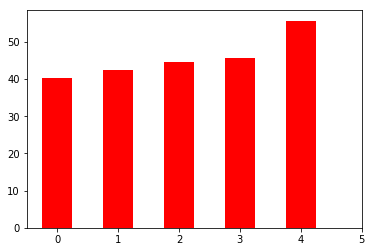

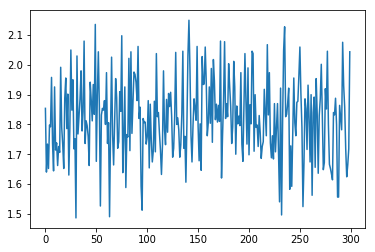

# of times the move was chosen: 
 [[37679. 21373.]
 [19488. 12663.]
 [10009.  5073.]
 [ 7478.  5637.]
 [27062.  3538.]]


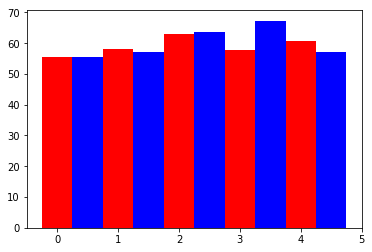

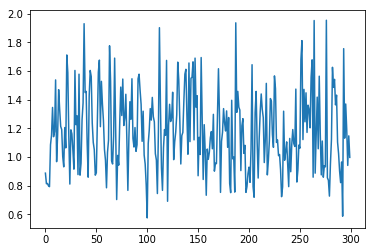

# of times the move was chosen: 
 [[     1. 120047.]
 [     0.  23995.]
 [     0.   4764.]
 [     0.    969.]
 [     0.    224.]]


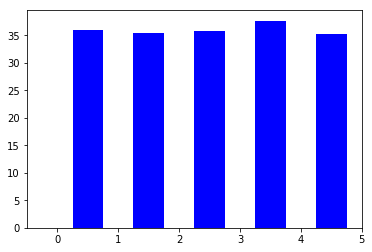

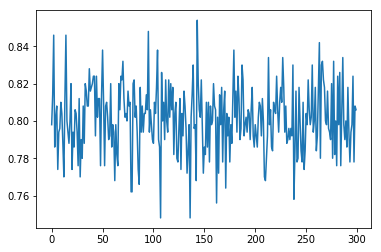

In [89]:
coins = np.zeros((5, 2))
coins_avg = []
moves = np.zeros((5, 2))
quality = np.zeros((5, 2))
lr = 0.8
y = 0.95
for i in range(300):
    s = env.reset()
    done = False
    while not done:
        if np.sum(quality[s, :]) == 0:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(quality[s, :])
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 1
        s = new_s
        new_s, r, done, _ = env.step(a)
        quality[s, a] += r + lr*(y*np.max(quality[new_s, :]) - quality[s, a])
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        #plot_bar(quality[:,0],quality[:,1])
        #time.sleep(0.001)
    coins_avg.append(np.sum(coins)/1000)
    coins = np.zeros((5, 2))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)
plot_bar(quality[:,0],quality[:,1])
plt.plot(coins_avg)
plt.show()

coins = np.zeros((5, 2))
coins_avg = []
moves = np.zeros((5, 2))
quality = np.zeros((5, 2))
lr = 0.8
y = 0.95
for i in range(300):
    s = env.reset()
    done = False
    while not done:
        if np.sum(quality[s, :]) == 0:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(quality[s, :])
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 1
        s = new_s
        new_s, r, done, _ = env.step(a)
        quality[s, a] += r + lr*(y*np.max(quality[new_s, :]) - quality[s, a])
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        #plot_bar(quality[:,0],quality[:,1])
        #time.sleep(0.001)
    coins_avg.append(np.sum(coins)/1000)
    coins = np.zeros((5, 2))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)
plot_bar(quality[:,0],quality[:,1])
plt.plot(coins_avg)
plt.show()

coins = np.zeros((5, 2))
coins_avg = []
moves = np.zeros((5, 2))
quality = np.zeros((5, 2))
lr = 0.8
y = 0.95
for i in range(300):
    s = env.reset()
    done = False
    while not done:
        if np.sum(quality[s, :]) == 0:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(quality[s, :])
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 1
        s = new_s
        new_s, r, done, _ = env.step(a)
        quality[s, a] += r + lr*(y*np.max(quality[new_s, :]) - quality[s, a])
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        #plot_bar(quality[:,0],quality[:,1])
        #time.sleep(0.001)
    coins_avg.append(np.sum(coins)/1000)
    coins = np.zeros((5, 2))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)
plot_bar(quality[:,0],quality[:,1])
plt.plot(coins_avg)
plt.show()

# of times the move was chosen: 
 [[71065. 32272.]
 [35062. 25831.]
 [13011. 10462.]
 [14715.  9937.]
 [27710.  9935.]]


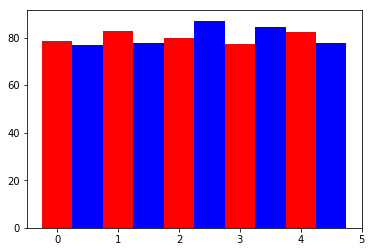

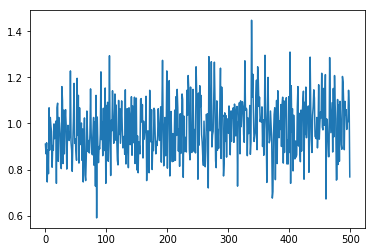

In [86]:
coins = np.zeros((5, 2))
coins_avg = []
moves = np.zeros((5, 2))
quality = np.zeros((5, 2))
learn_rate = 0.8
discount = 0.95
eps = 0.5
decay = 0.999
for i in range(500):
    s = env.reset()
    eps = eps * decay
    done = False
    while not done:
        if np.random.random() < eps or np.sum(quality[s, :]) == 0:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(quality[s, :])
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        moves[s, a] += 1
        s = new_s
        new_s, r, done, _ = env.step(a)
        quality[s, a] += r + learn_rate*(discount*np.max(quality[new_s, :]) - quality[s, a])
        # uncomment in case you want to visualize it graphically!
        #clear_output(wait=True)
        
        #time.sleep(0.001)
    coins_avg.append(np.sum(coins)/1000)
    coins = np.zeros((5, 2))
np.set_printoptions(suppress=True)
print("# of times the move was chosen: \n", moves)
np.set_printoptions(suppress=False)
plot_bar(quality[:,0],quality[:,1])
plt.plot(coins_avg)
plt.show()

# Dagobert and the power of deep learning

Having done all of the previous calculations above in numpy is an absolutely valid option. However, one needs to consider that other potential games Dagobert wants to learn require more states and more actions. In those cases, it is more suitable to use a neural network. 

Let's build a neural network for Dagobert's gym game.

Our model is going to look like this:

![title](img/NeuralN.png)

The input layer 

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer

model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 5)))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

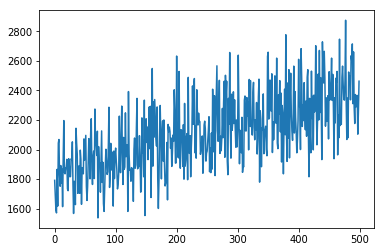

0.0


In [70]:
# now execute the q learning
coins = np.zeros((5, 2))
y = 0.95
eps = 0.5
decay_factor = 0.999
r_avg_list = []
coins_sum = []
for i in range(500):
    s = env.reset()
    eps *= decay_factor
    done = False
    r_sum = 0
    while not done:
        if np.random.random() < eps:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
        new_s, r, done, _ = env.step(a)
        coins[s, a] += r
        target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
        target_vec = model.predict(np.identity(5)[s:s + 1])[0]
        target_vec[a] = target
        model.fit(np.identity(5)[s:s + 1], target_vec.reshape(-1, 2), epochs=1, verbose=0)
        s = new_s
        r_sum += r
    r_avg_list.append(r_sum / 1000)
    coins_sum.append(np.sum(coins))
    coins = np.zeros((5, 2))
    clear_output(wait=True)
    plt.plot(coins_sum)
    plt.show()
    #time.sleep(0.001)


print(np.sum(coins))

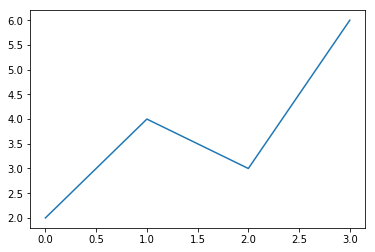

In [67]:
plt.plot([2,4,3,6])
plt.show()